<a href="https://colab.research.google.com/github/Parham-nooran/Reinforcement-Learning/blob/master/Temporal_Difference_vs_Monte_Carlo_Methods_%2B_TD(%CE%BB).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Temporal Difference vs. Monte Carlo Methods + TD(λ)


In this notebook, you are going to compare temporal difference learning (TD(0)) to the Monte Carlo method in Random Walk environment. Later, we introduce TD(λ) and you are going to implement it and find the connection between TD(λ) and TD(0), MC. You can change the default values as you see fit.

## Random Walk Env.

The environment you are going to use in your experiments, is depicted in the following picture. This is a random walk with two possible actions (`LEFT` and `RIGHT`) and 7 states, starting from state `C`. The agent gets a reward of 1 if it reaches the right-most state, and 0 otherwise. You are going to use such an environment with 21 states.

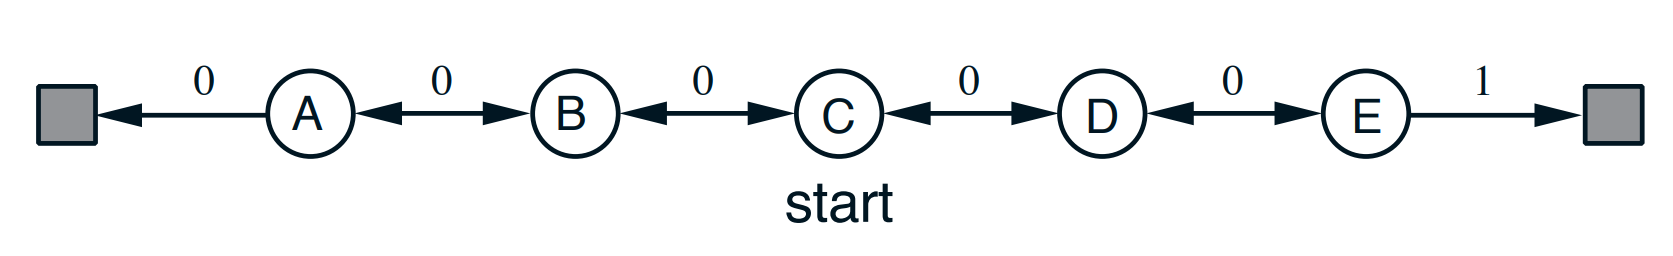

What is the true value for each state? How do you calculate it?


> **Answer:**
The true value of state s could be formulated as below: <br>
values(s) = R_ss' + gamma * values(s') <br>
where s R_ss' is the reward of transition from state s to s', gamma is the discount factor and is a hyperparameter and values(s') or V(s) is the value of state s' or the destination state of transition ss'.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class RandomWalkEnv():
    def __init__(self, num_states=21, start=10, gamma=1):
        self.num_states = num_states
        self.start = start
        self.end = num_states - 1
        self.gamma = gamma
        self.state = None
        self.actions = ['LEFT', 'RIGHT']

    def reset(self):
        self.state = self.start
        return self.state, 0, False

    def step(self, action):
        if self.state == self.end or self.state == 0:
            return self.state, 0, True
        action_direction = 0
        if action == 'RIGHT':
            action_direction = 1
        elif action == 'LEFT':
            action_direction = -1
        else:
            raise 'Invalid action. Choose from {"LEFT", "RIGHT"}.'

        self.state += action_direction
        reward, done = 0, False
        if self.state == self.end:
            reward, done = 1, True
        elif self.state == 0:
            done = True
        return self.state, reward, done

    def get_true_values(self):
        values = [0] * self.num_states
        ########################################################################
        # ToDo: Return the true value per state (1 point)
        rewards = [0] * self.end # self.num_states - 1
        rewards[self.end-1] = 1
        values[self.end] = 0
        for i in range(1, self.num_states):
          # values(s) = R_ss' + gamma * values(s')
          values[self.end - i] = rewards[self.end - i] + self.gamma * values[self.end - i + 1]
        ########################################################################
        return values

# An example of instantiation and usage
rw_env = RandomWalkEnv()

true_values = rw_env.get_true_values() # use this method to get the true values for RMS calculation later.
print('\nOptimal values:')
for i, v in enumerate(true_values):
    print(f'\tV*({i}) = {v:.4f}')

state, reward, done = rw_env.reset()
print('\nSteps in the optimal episode:')
while not done:
    state, reward, done = rw_env.step('RIGHT')
    print('\t', state, reward, done)


Optimal values:
	V*(0) = 1.0000
	V*(1) = 1.0000
	V*(2) = 1.0000
	V*(3) = 1.0000
	V*(4) = 1.0000
	V*(5) = 1.0000
	V*(6) = 1.0000
	V*(7) = 1.0000
	V*(8) = 1.0000
	V*(9) = 1.0000
	V*(10) = 1.0000
	V*(11) = 1.0000
	V*(12) = 1.0000
	V*(13) = 1.0000
	V*(14) = 1.0000
	V*(15) = 1.0000
	V*(16) = 1.0000
	V*(17) = 1.0000
	V*(18) = 1.0000
	V*(19) = 1.0000
	V*(20) = 0.0000

Steps in the optimal episode:
	 11 0 False
	 12 0 False
	 13 0 False
	 14 0 False
	 15 0 False
	 16 0 False
	 17 0 False
	 18 0 False
	 19 0 False
	 20 1 True


## TD(0) vs. MC

Now let's implement MC and TD(0). Run both methods on the environment for 100 episodes and plot the RMS (for value function) vs. episodes for each method. Initialize the value approximation by 0.5 for all states. Calculate the RMS error only for non-terminal states. Use purely random policy to maximally explore the environment.

In [ ]:
def TD_0(env, num_episodes, alpha=0.1):
    gamma = env.gamma
    values = [0.5] * env.num_states
    errors = []
    ############################################################################    
    # ToDo: Implement TD(0) here (4 points).
    true_values = env.get_true_values()
    for episode in range(num_episodes):
      state, reward, done = env.reset()
      while not done:
        action = np.random.choice(env.actions, size=1)
        next_state, reward, done = env.step(action)
        values[state] = values[state] + alpha * (reward + gamma * values[next_state] - values[state])
        state = next_state
      errors.append(np.sqrt(np.mean((np.array(values)[1:-1] - np.array(true_values)[1:-1])**2)))
    ############################################################################
    return values, errors

In [ ]:
from collections import defaultdict
def MC(env, num_episodes, alpha=0.1):
    gamma = env.gamma
    values = np.array([0.5] * env.num_states)
    Q = defaultdict(lambda: np.full(len(env.actions), fill_value=0.5))
    errors = []
    ############################################################################
    # ToDo: Implement MC here (5 points).
    true_values = env.get_true_values()
    for episode in range(num_episodes):
      state, reward, done = env.reset()
      # Generate an episode
      episode = []
      while not done:
        action = np.random.choice(env.actions, size=1)
        next_state, reward, done = env.step(action)
        episode.append((state, action, reward))
        state = next_state
      # Update values
      states, actions, rewards = zip(*episode)
      discounts = np.array([gamma**i for i in range(len(rewards)+1)])
      for i, state in enumerate(states):
        Q[state][0 if actions[i] == "RIGHT" else 1] = Q[state][0 if actions[i] == "RIGHT" else 1] + alpha * (sum(rewards[i:] * discounts[:-(i+1)]) - Q[state][0 if actions[i] == "RIGHT" else 1])
      values[list(Q.keys())] = np.array([max(v) for v in Q.values()])
      errors.append(np.sqrt(np.mean((values[1:-1] - np.array(true_values)[1:-1])**2)))
    ############################################################################
    return values, errors

TD Values [0.5, 0.5017404391571402, 0.5049216498856942, 0.5138469353061548, 0.5189491903142867, 0.5281873355165665, 0.5480021686865886, 0.5629207359534315, 0.5834175248552529, 0.6098465580262403, 0.650002856966937, 0.6996919622933648, 0.7654729781527794, 0.8142529670423823, 0.9061080573105381, 0.9650809139834958, 1.0257813461814917, 1.1071039969345273, 1.2556690839818025, 1.3986039034340703, 0.5]
MC Values [0.5        0.12165605 0.0617364  0.02764852 0.18245333 0.31793871
 0.63951369 0.78259977 0.89978408 0.86800584 0.79697685 0.96701731
 0.92881593 0.95789118 0.97641084 0.97114021 0.95765758 0.98422749
 0.99993671 0.99713679 0.5       ]


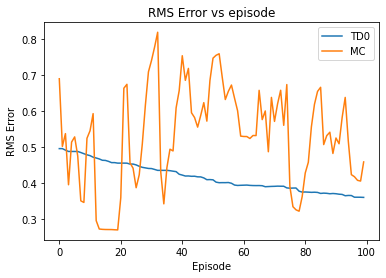

In [ ]:
# Run the experiment and plot RMS/episodes (2 points).
rw_env = RandomWalkEnv()
td_values, td_errors = TD_0(rw_env, num_episodes=100)
mc_values, mc_errors = MC(rw_env, num_episodes=100)
print("TD Values", td_values)
print("MC Values", mc_values)
plt.plot(td_errors, label='TD0')
plt.plot(mc_errors, label='MC')
plt.xlabel("Episode")
plt.ylabel("RMS Error")
plt.title("RMS Error vs episode")
plt.legend()
plt.show()

Answer the following questions:


1.   In general, what are the advantages of TD(0) over MC, and vice versa? Which one converges faster? Which one estimates the value function better?


> **Answer: (2 points)**
1. TD0 estimates the vlaue function directly but MC is for Q-function estimation.  
2. TD0 is less random.
TD0 converges faster compared to MC and as it is shown by the RMS plot, TD0 has fewer ups and downs in the resulted RMS of each episode, which reults in faster convergence. 

2.   How does your results align with your answers to the previous question?


> **Answer: (1 point)**

As it is shown by the results, both algorithms are converging to the true values of the environment (returned by the get_true_values function). It is also shown that TD0 algorithm is doing better than MC in general.


## TD(λ)

In order to unify the advantages of both methods, one can think of n-step TD where the update to the value function is performed using the rewards from last n-steps, instead of only the last step. But it is difficult to find the suitable n for different tasks. An idea is to average the value between all possible ns. This gives rise to TD(λ) where a weighted average of n-step updates is calculated, but instead of using direct weights, it uses λ as a parameter to control the weight and make it sum up to 1.

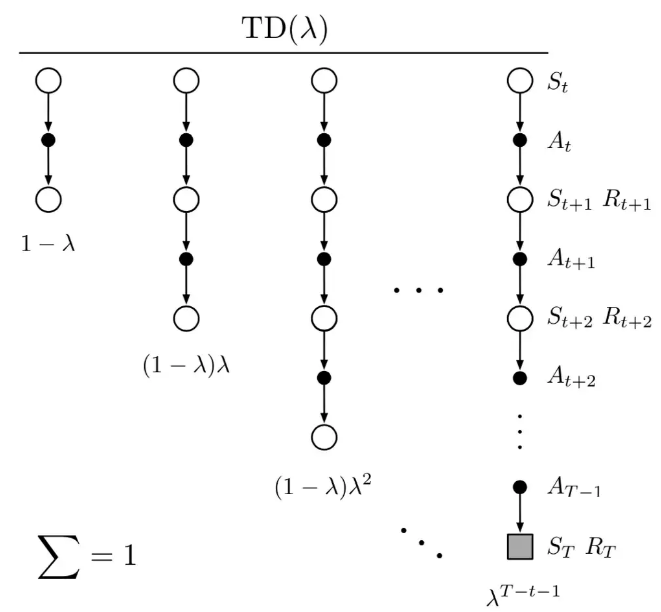

Let’s build up the intuition for TD(λ) by expanding the TD(0) error. For this, we’ll talk about the n-step returns of a trajectory. The `n=1` return is the TD(0) target.

$$
n = 1 → G_t^{(1)} = r_{t+1} + \gamma \hat{v}_\pi(s_{t+1})
$$
$$
n = 2 → G_t^{(2)} = r_{t+1} + \gamma r_{t+2} + \gamma^2 \hat{v}_\pi(s_{t+2})
$$
$$
.\\
.\\
.\\
$$
$$
\forall n → G_t^{(n)} = r_{t+1} + \gamma r_{t+2} + ... + \gamma^{n-1} t_{t+n} + \gamma^n \hat{v}_\pi(s_{t+n})
$$

So, in order to perform n-step TD-learning, we can replace the TD(0) target, which is the $G_t^{(1)}$, with the n-step return, $G_t^{(n)}$. Our update for the state-value function becomes:

$$
\delta_t = G_t^{(n)} - \hat{v}_\pi(s_t)
$$
$$
\hat{v}_\pi (s_t) ← \hat{v}_\pi (s_t) + \alpha \delta_t
$$

For TD(λ), we can define the *λ-return* target for the episodic case as below, and plug it into the update rule. It is just the averaging method depicted in the above image.

$$
G_t^{(\lambda)} = (1 - \lambda) \sum_{n=1}^{T-t-1} \lambda^{n-1} G^{(n)}_t + \lambda^{T-t-1} G_t
$$
$$
G_t = \sum_{i=t+1}^T \gamma^{i-t-1}r_i
$$

As you can see, the λ-return involves all of the possible n-step returns and as a consequence, involves information from every time step of our trajectory. So we need to wait for a trajectory to be completed, and then we will be able to calculate every possible n-step return and combine them using the λ-weighted average (This is called the *forward view* of TD(λ)). But the λ-weighting scheme will allow us to use a trick that enables online updates while being virtually equivalent to the intuition we derived above. To do this, we’ll use something called an *eligibility trace* and leads to the *backward view* of TD(λ). An eligibility trace (dutch version) is defined as $E_t(s)$:

$$
\\
E_0(s) = 0, \forall s \in S \\
E_t(s) = \lambda \gamma \Big((1-\alpha)E_{t-1}(s) + I(s_t = s)\Big)
\\
$$

where $I(condition)$ is 1 if the $condition$ holds, and 0 otherwise. We now use the eligibility value as a scaling factor for a TD(0) error. The trick here is hidden in the fact that every state is updated at once. In other words, we propagate current error information into the states we visited in the past. This allows us to combine the n-step returns in an online fashion. So, for example, if we’re interacting with the environment and see a reward $r_{t+1}$, our update to the state-value function will be:

$$
\\
\delta_t ← r_{t+1} + \gamma \hat{v}_\pi(s_{t+1}) - \hat{v}_\pi(s_{t})\\
\hat{v}_\pi(s) ← \hat{v}_\pi(s) + \alpha \delta_t E_t(s), ∀s \in S
\\
$$



If all updates are aggregated to the final step of the episode, we have the *offline* TD(λ), and if the updates are performed at every single step, we have the *online* version of the method. Now, let's implement the online TD(λ) with the backward view. To learn more details, please refer to Sutton & Barto, Ch. 7.

In [ ]:
def TD_lambda(env, num_episodes, lambda_parameter, alpha=0.1):
    gamma = env.gamma
    values = np.array([0.5] * env.num_states)
    eligibility_traces = np.array([0.] * env.num_states)
    errors = []
    ############################################################################
    # ToDo: Implement online TD(λ)
    true_values = env.get_true_values()
    for episode in range(num_episodes):
      state, reward, done = env.reset()
      while not done:
        action = np.random.choice(env.actions, size=1)
        # delta <-- R + V (S') - V (S); S' = next_state, S = state; Embeded on the following code
        next_state, reward, done = env.step(action)
        eligibility_traces[state] = (1 - alpha) * eligibility_traces[state] + 1
        # V (s) <-- V (s) + alpha*delta*E(s)
        values[state] = values[state] + alpha * (reward + gamma * values[next_state] - values[state]) * eligibility_traces[state]
        # E(s) <-- lambda*gamma*E(s)
        eligibility_traces *= lambda_parameter * gamma
        state = next_state
      errors.append(np.sqrt(np.mean((np.array(values)[1:-1] - np.array(true_values)[1:-1])**2)))
    ############################################################################
    return values, errors

Compare the performance (RMS vs. episode) for different λs $\in \{0, 0.4, 0.8, 0.95, 1\}$. Plot the results.

TD0 Values [0.5, 0.5017404391571402, 0.5049216498856942, 0.5138469353061548, 0.5189491903142867, 0.5281873355165665, 0.5480021686865886, 0.5629207359534315, 0.5834175248552529, 0.6098465580262403, 0.650002856966937, 0.6996919622933648, 0.7654729781527794, 0.8142529670423823, 0.9061080573105381, 0.9650809139834958, 1.0257813461814917, 1.1071039969345273, 1.2556690839818025, 1.3986039034340703, 0.5]
TD0.4 Values [0.5, 0.5017404391571402, 0.5049216498856942, 0.5138469353061548, 0.5189491903142867, 0.5281873355165665, 0.5480021686865886, 0.5629207359534315, 0.5834175248552529, 0.6098465580262403, 0.650002856966937, 0.6996919622933648, 0.7654729781527794, 0.8142529670423823, 0.9061080573105381, 0.9650809139834958, 1.0257813461814917, 1.1071039969345273, 1.2556690839818025, 1.3986039034340703, 0.5]
TD0.8 Values [0.5, 0.5017404391571402, 0.5049216498856942, 0.5138469353061548, 0.5189491903142867, 0.5281873355165665, 0.5480021686865886, 0.5629207359534315, 0.5834175248552529, 0.609846558026240

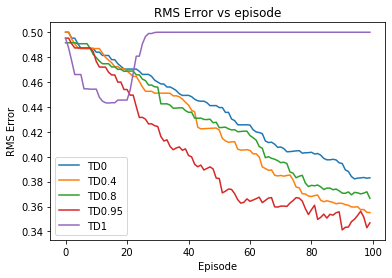

In [ ]:
# Run the aforementioned experiments and plot the curves.
rw_env = RandomWalkEnv()
lambdas = [0, 0.4, 0.8, 0.95, 1]
for lambda_ in lambdas:
  td_lambda_values, td_lambda_errors = TD_lambda(rw_env, num_episodes=100, lambda_parameter=lambda_)
  print(f"TD{lambda_} Values", td_values)
  plt.plot(td_lambda_errors, label=f'TD{lambda_}')
plt.xlabel("Episode")
plt.ylabel("RMS Error")
plt.title("RMS Error vs episode")
plt.legend()
plt.show()

Answer the following questions:


1.   Which λ is optimal? Why?

> **Answer (1 points):**

λ = 0.95; Using λ=0.95 we get the minimum RMS error after 100 episodes. Using λ=0.4 we get the smoothest RMS error plot in 100 episodes and λ=0.4 is the next best λ for this problem.

2.   Compare the results of $\lambda = 0$ and $\lambda = 1$ to the TD(0) and MC methods implemented in the first part of the notebook. Do you see any correspondances? Explain your observations in terms of the definition of update rules in each method.

> **Answer (2 points):**

As it's shown by the plot, λ=0.95 gives the smallest and λ=1 gives the largest RMS error. Using λ=1 causes the RMS plot to get an RMS error equal to the default case (initial values for the predicted variables) after passing around 20 episodes. Changing λ from 0 to 0.4 or 0.8 does make so much difference in both noisiness and optimalitiness of the answer.
As we know the lambda parameter is determining the decay of the eligibility rate. Setting λ=1 results in no decay or reductions witch eventually causes the algorithm to break. Setting a small value for λ makes the eligibility to decay faster but does not break the algorithm while also not helping the end goal to be achieved. So we can finally conclude that a decay between 0 to .1 or a lambda parameter between 0.9 to 1 is the most desirable and effective. 